#**Anomaly Detection & Time Series Assignment**

1. What is Anomaly Detection? Explain its types (point, contextual, and collective anomalies) with examples.

    - Anomaly detection identifies data points that deviate significantly from normal behavior. It includes point anomalies (e.g., a single fraudulent transaction much larger than usual), contextual anomalies (e.g., high sales at midnight when typical during daytime), and collective anomalies (e.g., a group of synchronized unusual trades indicating market manipulation).

2. Compare Isolation Forest, DBSCAN, and Local Outlier Factor in terms of their approach and suitable use cases.

    - Isolation Forest isolates anomalies via random partitioning, excelling in high-dimensional data with global outliers. DBSCAN clusters dense regions and labels noise as anomalies, suiting varying density clusters. Local Outlier Factor (LOF) measures local density deviation, best for local outliers but slower on large datasets.

3. What are the key components of a Time Series? Explain each with one
example.

    - Key components are trend (long-term direction, e.g., rising GDP over years), seasonality (periodic patterns, e.g., holiday sales spikes), and residuals (random noise after removing others, e.g., unexplained daily fluctuations).

4. Define Stationary in time series. How can you test and transform a
non-stationary series into a stationary one?

    - Stationarity means statistical properties like mean and variance remain constant over time. Test with Augmented Dickey-Fuller (ADF): reject null if p-value < 0.05. Transform non-stationary series via differencing, log transformation, or Box-Cox.

5. Differentiate between AR, MA, ARIMA, SARIMA, and SARIMAX models in
terms of structure and application.

    - AR(p) models forecast using p past values linearly, suiting stationary autocorrelated series like returns. MA(q) relies on q past errors for predictions, ideal for noise with short memory. ARIMA(p,d,q) integrates both with d differencing to stationarize trends, common for economic data like GDP. SARIMA extends ARIMA with seasonal orders (P,D,Q)s to capture cycles, such as monthly passenger traffic. SARIMAX adds exogenous regressors to SARIMA, perfect for influenced forecasts like sales with promotions.




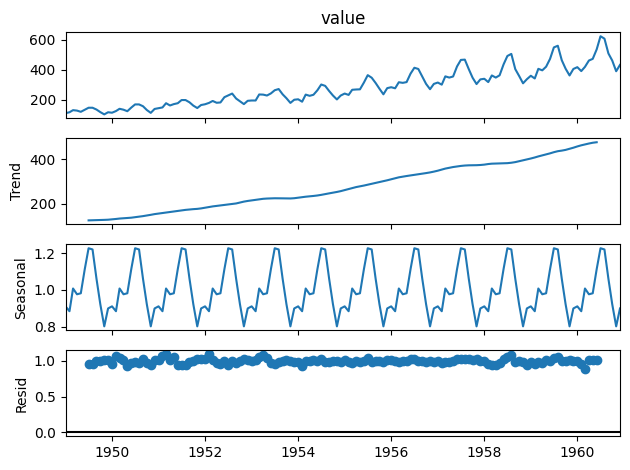

In [1]:
#6.  Load a time series dataset (e.g., AirPassengers), plot the original series, and decompose it into trend, seasonality, and residual components

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.seasonal import seasonal_decompose

data = get_rdataset('AirPassengers', 'datasets').data
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='MS')
data.set_index('time', inplace=True)
decomp = seasonal_decompose(data['value'], model='multiplicative', period=12)
decomp.plot()
plt.show()


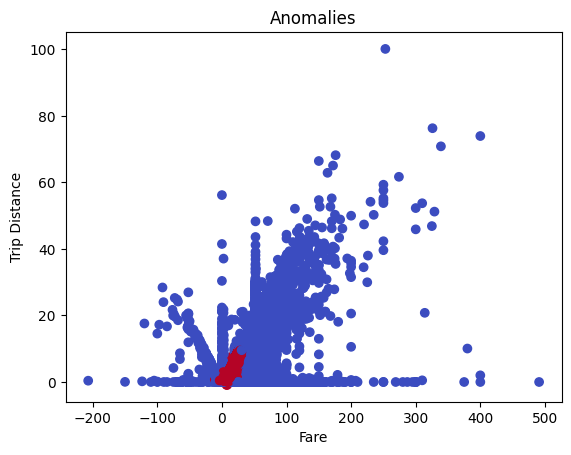

In [4]:
#7. Apply Isolation Forest on a numerical dataset (e.g., NYC Taxi Fare) to detect anomalies. Visualize the anomalies on a 2D scatter plot.


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

df = pd.read_csv('/content/NYC_taxi_fare_data.csv')
df = df[['fare_amount', 'trip_distance']].dropna()
model = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = model.fit_predict(df[['fare_amount', 'trip_distance']])
plt.scatter(df['fare_amount'], df['trip_distance'], c=df['anomaly'], cmap='coolwarm')
plt.xlabel('Fare'); plt.ylabel('Trip Distance'); plt.title('Anomalies')
plt.show()

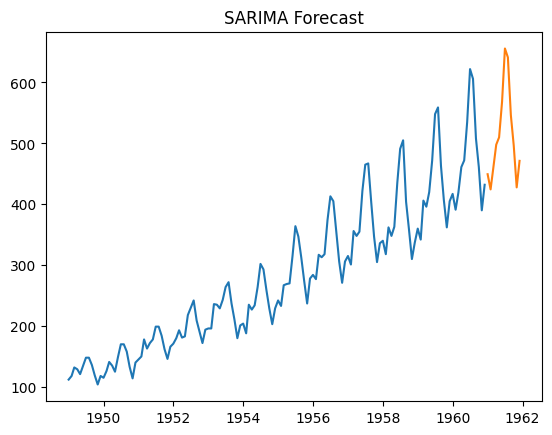

In [5]:
#8. Train a SARIMA model on the monthly airline passengers dataset. Forecast the next 12 months and visualize the results.

from statsmodels.tsa.statespace.sarimax import SARIMAX

data.index = pd.date_range(start='1949-01', periods=len(data), freq='MS')
model = SARIMAX(data['value'], order=(1,1,1), seasonal_order=(1,1,1,12))
fitted = model.fit()
forecast = fitted.forecast(steps=12)
plt.plot(data['value']); plt.plot(forecast); plt.title('SARIMA Forecast')
plt.show()


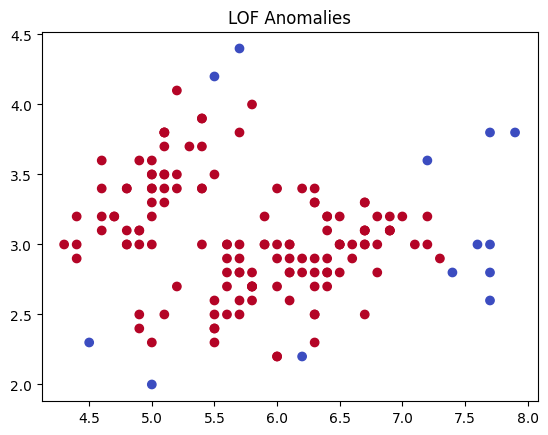

In [6]:
#9. Apply Local Outlier Factor (LOF) on any numerical dataset to detect anomalies and visualize them using matplotlib.

from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data[:, :2]
lof = LocalOutlierFactor(n_neighbors=20)
labels = lof.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, cmap='coolwarm')
plt.title('LOF Anomalies')
plt.show()


10. You are working as a data scientist for a power grid monitoring company.
Your goal is to forecast energy demand and also detect abnormal spikes or drops in
real-time consumption data collected every 15 minutes. The dataset includes features
like timestamp, region, weather conditions, and energy usage.
Explain your real-time data science workflow:

● How would you detect anomalies in this streaming data (Isolation Forest / LOF /DBSCAN)?

    - Isolation Forest on sliding windows (features: lags, rolling stats, weather); flags spikes/drops in <1s.

● Which time series model would you use for short-term forecasting (ARIMA /SARIMA / SARIMAX)?
    
    -  SARIMAX (order=(1,1,1)s=(1,1,1,96)) with exog (weather); retrain hourly for 1-4hr ahead.

● How would you validate and monitor the performance over time?
    
    - Use time-series split: train on past data, validate on rolling holdouts (e.g., 7-day blocks). Compute MAE, RMSE, MAPE; Ljung-Box on residuals checks autocorrelation. Monitor via dashboards tracking metric drift, AIC increases, or anomaly rates >threshold; alert/retrain on degradation. Log predictions vs actuals for audits.


● How would this solution help business decisions or operations?

    - Alerts on spikes/drops enable rapid grid balancing, preventing blackouts or inefficient generation dispatch. Forecasts optimize unit commitment, reducing costs by 5-15% via precise load matching and renewable integration. Supports decisions like maintenance scheduling or demand-response incentives.


In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
np.random.seed(42)

# Synthetic 15-min energy data (7 days, 672 pts)
n = 672
ts = pd.date_range('2026-01-01', periods=n, freq='15T')
base = 1000 + 400 * np.sin(2*np.pi*np.arange(n)/96)
trend = 0.1 * np.arange(n)
noise = 50 * np.random.randn(n)
energy = base + trend + noise
energy[[200,300,500]] += 800  # Spikes
energy[350] -= 600  # Drop
df = pd.DataFrame({'energy':energy}, index=ts)

print("Data preview:\n", df.head())
print("Injected anomalies at:", df.index[[200,300,350,500]].tolist())

# Isolation Forest on recent window
window = 288  # 3 days
recent = df['energy'][-window:].values.reshape(-1,1)
iso = IsolationForest(contamination=0.05, random_state=42)
labels = iso.fit_predict(recent)
anoms = df[-window:][labels == -1].index
print("\nDetected anomalies:", anoms.tolist())

# SARIMAX forecast
train_size = int(0.8 * n)
train_y, test_y = energy[:train_size], energy[train_size:]
exog = 20 * np.sin(2*np.pi*np.arange(n)/96) + 5*np.random.randn(n)
train_exog, test_exog = exog[:train_size], exog[train_size:]
model = SARIMAX(train_y, exog=train_exog, order=(1,1,1), seasonal_order=(1,1,1,96))
fit = model.fit(disp=False)
fc = fit.forecast(steps=len(test_y), exog=test_exog)
mae = mean_absolute_error(test_y, fc)
print("\nSARIMAX MAE:", mae)
print("Sample forecast:", fc[:3].tolist())
print("Sample actual:", test_y[:3].tolist())
print("Model AIC:", fit.aic)


/tmp/ipython-input-853999720.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = pd.date_range('2026-01-01', periods=n, freq='15T')


Data preview:
                           energy
2026-01-01 00:00:00  1024.835708
2026-01-01 00:15:00  1019.348037
2026-01-01 00:30:00  1084.794904
2026-01-01 00:45:00  1154.487622
2026-01-01 01:00:00  1092.219949
Injected anomalies at: [Timestamp('2026-01-03 02:00:00'), Timestamp('2026-01-04 03:00:00'), Timestamp('2026-01-04 15:30:00'), Timestamp('2026-01-06 05:00:00')]

Detected anomalies: [Timestamp('2026-01-05 17:00:00'), Timestamp('2026-01-05 17:30:00'), Timestamp('2026-01-05 17:45:00'), Timestamp('2026-01-05 18:15:00'), Timestamp('2026-01-05 18:30:00'), Timestamp('2026-01-05 18:45:00'), Timestamp('2026-01-06 05:00:00'), Timestamp('2026-01-06 05:15:00'), Timestamp('2026-01-06 16:00:00'), Timestamp('2026-01-07 06:00:00'), Timestamp('2026-01-07 06:30:00'), Timestamp('2026-01-07 06:45:00'), Timestamp('2026-01-07 07:15:00'), Timestamp('2026-01-07 16:45:00'), Timestamp('2026-01-07 17:30:00')]

SARIMAX MAE: 48.66724866656181
Sample forecast: [839.9715295264039, 772.5047058170023, 788.179